# Local Global Trend (LGT)

In this section, we will cover:

- LGT model structure
- difference between DLT and LGT
- syntax to call LGT classes with different estimation methods

**LGT** stands for Local and Global Trend and is a refined model from **Rlgt** [(Smyl et al., 2019)](https://cran.r-project.org/web/packages/Rlgt/index.html).  The main difference is that LGT is an additive form taking log-transformation response as the modeling response.  This essentially converts the model into a multicplicative with some advantages [(Ng and Wang et al., 2020)](https://arxiv.org/abs/2004.08492).  **However, one drawback of this approach is that negative response values are not allowed due to the existence of the global trend term and because of that we start to deprecate the support of regression of this model.**

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from orbit.models.lgt import LGTMAP, LGTAggregated, LGTFull
from orbit.diagnostics.plot import plot_predicted_data
from orbit.diagnostics.plot import plot_predicted_components
from orbit.utils.dataset import load_iclaims

## Model Structure

$$
\begin{align*}
 y_{t}  &= \mu_t + s_t   + \epsilon_t \\
\mu_t &= l_{t-1} + \xi_1 b_{t-1} + \xi_2 l_{t-1}^{\lambda}\\
\epsilon_t  &~\sim \mathtt{Student}(\nu, 0, \sigma)\\
\sigma &~\sim  \mathtt{HalfCauchy}(0, \gamma_0)
\end{align*}
$$

with the update process,

$$
\begin{align*}
l_t &= \rho_l(y_t - s_t) + (1-\rho_l)l_{t-1}\\
b_t &=  \rho_b(l_t - l_{t-1}) + (1-\rho_b)b_{t-1}\\
s_{t+m} &=  \rho_s(y_t - l_t ) + (1-\rho_s)s_t
\end{align*}
$$

Unlike **DLT** model which has a deterministic trend, **LGT** introduces a hybrid trend where it consists of 

- local trend takes on a fraction $\xi_1$ rather than a damped factor
- global trend is with a auto-regrssive term $\xi_2$ and a power term $\lambda$

We will continue to use the *iclaims* data with 52 weeks train-test split.

In [2]:
# load data
df = load_iclaims()
# define date and response column
date_col = 'week'
response_col = 'claims'
df.dtypes
test_size = 52
train_df = df[:-test_size]
test_df = df[-test_size:]

## LGT Model

In orbit, we have three types of LGT models, `LGTMAP`, `LGTAggregated` and  `LGTFull`.
Orbit follows a sklearn style model API. We can create an instance of the Orbit class and then call its fit and predict methods.

### LGTMAP

**LGTMAP** is the model class for MAP (Maximum a Posteriori) estimation.

In [3]:
lgt = LGTMAP(
    response_col=response_col,
    date_col=date_col,
    seasonality=52,
    seed=8888,
)

In [4]:
%%time
lgt.fit(df=train_df)

CPU times: user 228 ms, sys: 13.2 ms, total: 241 ms
Wall time: 318 ms


In [5]:
predicted_df = lgt.predict(df=test_df)

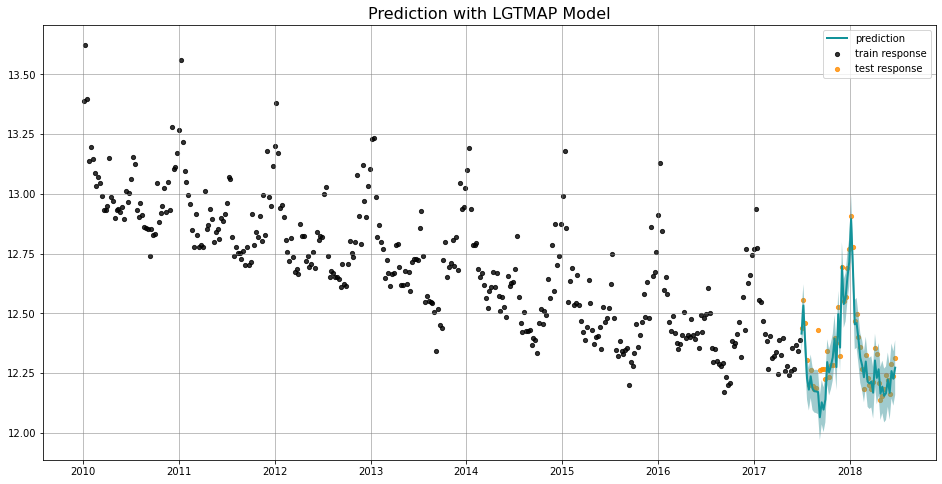

In [6]:
_ = plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                        date_col=date_col, actual_col=response_col,  
                        test_actual_df=test_df, title='Prediction with LGTMAP Model')

### LGTFull

**LGTFull** is the model class for full Bayesian prediction. In full Bayesian prediction, the prediction will be conducted once for each parameter posterior sample, and the final prediction results are aggregated. Prediction will always return the median (aka 50th percentile) along with any additional percentiles that are provided.

In [7]:
lgt = LGTFull(
    response_col=response_col,
    date_col=date_col,
    seasonality=52,
    seed=8888,
)

In [8]:
%%time
lgt.fit(df=train_df)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


CPU times: user 98.5 ms, sys: 94.5 ms, total: 193 ms
Wall time: 11.2 s


In [9]:
predicted_df = lgt.predict(df=test_df)

In [10]:
predicted_df.tail(5)

,week,prediction_5,prediction,prediction_95
47,2018-05-27,12.099949,12.232984,12.330652
48,2018-06-03,12.060341,12.173674,12.293869
49,2018-06-10,12.118473,12.262561,12.408782
50,2018-06-17,12.097858,12.239122,12.341881
51,2018-06-24,12.193468,12.281816,12.383324


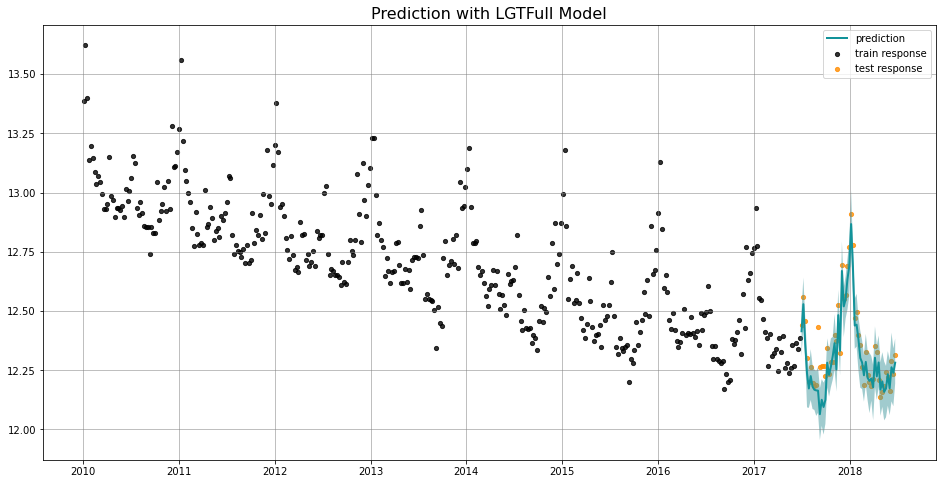

In [11]:
_ = plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=lgt.date_col, actual_col=lgt.response_col, 
                    test_actual_df=test_df, title='Prediction with LGTFull Model')

### LGTAggregated

**LGTAggregated** is the model class for aggregated posterior prediction. In aggregated prediction, the parameter posterior samples are reduced using `aggregate_method ({ 'mean', 'median' })` before performing a single prediction.

In [12]:
lgt = LGTAggregated(
    response_col=response_col,
    date_col=date_col,
    seasonality=52,
    seed=8888,
)

In [13]:
%%time
lgt.fit(df=train_df)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


CPU times: user 219 ms, sys: 186 ms, total: 405 ms
Wall time: 13 s


In [14]:
predicted_df = lgt.predict(df=test_df)

In [15]:
predicted_df.tail(5)

,week,prediction_5,prediction,prediction_95
47,2018-05-27,12.091428,12.204437,12.313660
48,2018-06-03,12.031525,12.139519,12.250433
49,2018-06-10,12.124013,12.233509,12.345642
50,2018-06-17,12.090025,12.200898,12.311468
51,2018-06-24,12.138503,12.247008,12.357515


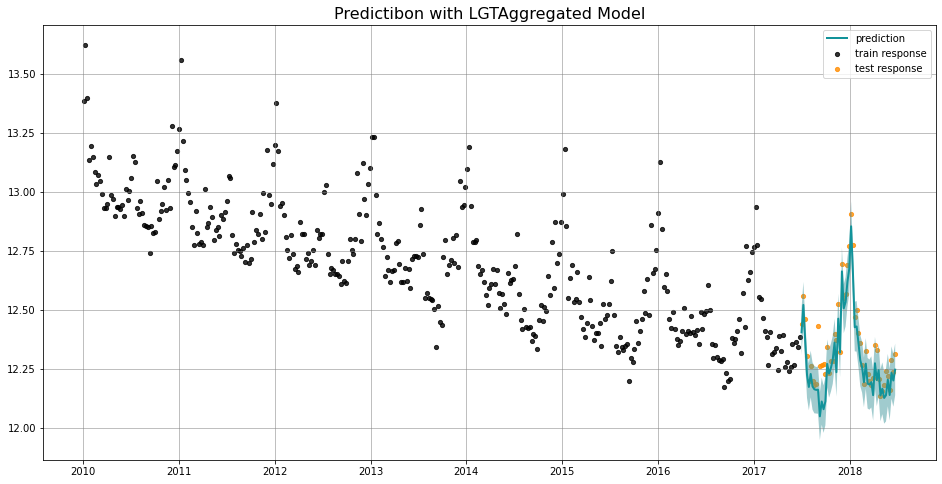

In [16]:
_ = plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=lgt.date_col, actual_col=lgt.response_col, 
                    test_actual_df=test_df, title='Predictibon with LGTAggregated Model')

More details for each method are available in the docstrings and also here: https://uber.github.io/orbit/orbit.models.html#module-orbit.models.lgt